In [174]:
# Too many imports
import pandas as pd
from matplotlib import pyplot
from sklearn import ensemble, model_selection, metrics
import seaborn as sns
import numpy
import ipywidgets as widgets
from IPython.display import display
import math
from collections import Counter

In [175]:
# This function breaks down passwords according to their features
def extract_features(password):

    # calculate entropy for entropy_model, used for boosting model accuracy
    def calculate_entropy(password):
        # Counts the number of times a specific character appears in a password
        char_count = Counter(password)
        # probability of each character appearing in the password, lower is better.
        prob = [count / len(password) for count in char_count.values()]
        # Shannon entropy formula
        entropy = (-sum(p * math.log(p) for p in prob))
        
        return entropy

    
    features = {
        'password': password,
        'length': len(password),
        'uppercase_letters': sum(1 for c in password if c.isupper()),
        'lowercase_letters': sum(1 for c in password if c.islower()),
        'numbers': sum(1 for c in password if c.isdigit()),
        'special': sum(1 for c in password if not c.isalnum()),
        'entropy_model': calculate_entropy(password)
    }
    return features

In [176]:
# Creation of universal data frame
u_df = pd.read_csv('Thisdata.csv')
u_df = pd.merge(pd.DataFrame([extract_features(password) for password in u_df['password']]), u_df, on='password')
# Logs the crack_time_sec column to make it graphable.
u_df['crack_time_sec(log)'] = numpy.log(u_df['crack_time_sec'])
# When you take the log of a number that is less than 1 the log will be a negative number
# Since we are dealing with time here you cannot have negative time so it would need to be made 0
# Any number that is being made 0 is less than a real-world second which is essentially instant anyway, at least in this context.
u_df.loc[u_df['crack_time_sec(log)'] < 0, 'crack_time_sec(log)'] = 0

# data frame used for model
# Model uses different entropy so it can be reproduced for user input passwords.
m_df = u_df[['password', 'length', 'uppercase_letters', 'lowercase_letters', 'numbers', 'special', 'entropy_model', 'class_strength']]

<div style="text-align: center;">
  <h1>Passy</h1>
  <h2>Password Categorization Tool</h2>
</div>
<br>

<p>A strong password is essential in the modern age of technology. The purpose of this tool is to show what makes a good password and categorize a user's password.</p>
<br>

<h3>Entropy</h3>
<p>Entropy is the randomness of a password, the more random a password seems the harder it is to crack. Below is a graph that shows the relationship between the entropy of a password and how long it would take to crack in a natural log of real-world seconds.</p>

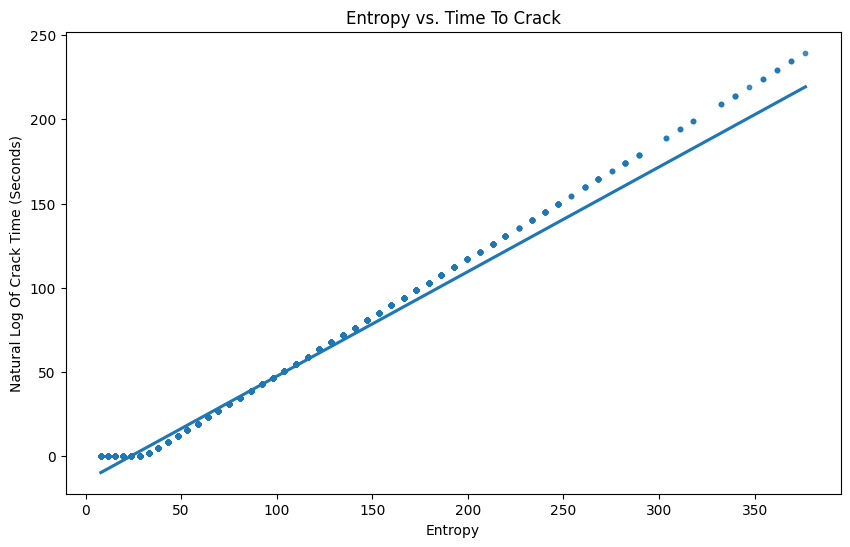

In [177]:
# Scatterplot graph with regression line
pyplot.figure(figsize=(10, 6))
# Pulls 'entropy' and 'crack_time_sec(log)' from u_df
# Uses entropy provided by the dataset
sns.regplot(x='entropy', y='crack_time_sec(log)', data=u_df, scatter_kws={'s':10})

# Labels
pyplot.xlabel('Entropy')
pyplot.ylabel('Natural Log Of Crack Time (Seconds)')
pyplot.title('Entropy vs. Time To Crack')
pyplot.show()

<p>As you can see the relationship between entropy and the crack time of a password is linear. This graph shows how important it is to have a random password. I would also like to explain the y-axis better, this is the natural log of real-world seconds. The strongest passwords on this graph would take lifetimes to crack in real-world seconds. However, when you take the natural log of a number that is less than 1 it becomes a negative number. In this case, that means that the password would have been cracked in less than a real-world second. For this graph, all the passwords that would have been cracked in less than a real-world second have been set to 0, meaning their crack time is instant. Having as much randomness in a password as possible will ensure that it will be a stronger password.</p>
<br>

<h3>Length</h3>
<p>Entropy is not the only important aspect of making a strong password. The length of a password is also important, the graph below shows the distribution in the length of passwords across the different categories this tool has.</p>

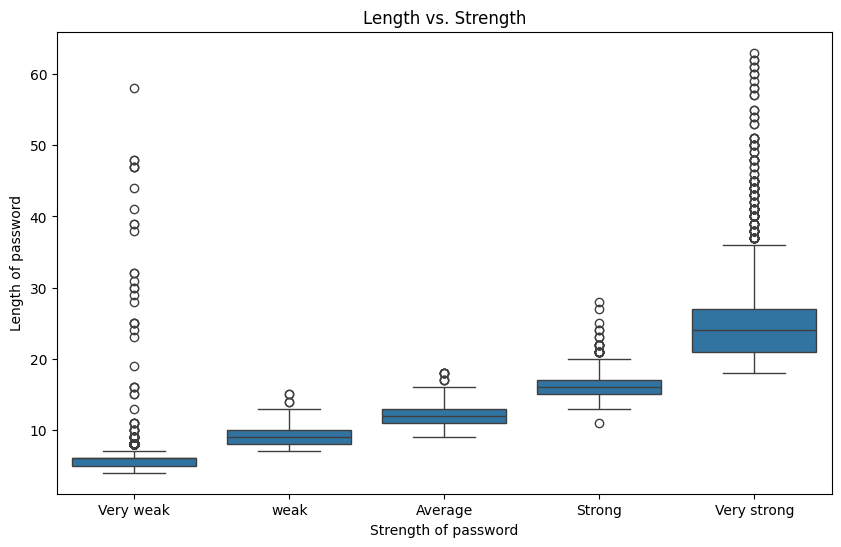

In [178]:
# Box plot graph
pyplot.figure(figsize=(10, 6))
# Pull 'class_strength' and 'length' from u_df
sns.boxplot(x='class_strength', y='length', data=u_df)

# Labels
pyplot.xlabel('Strength of password')
pyplot.ylabel('Length of password')
pyplot.title('Length vs. Strength')
pyplot.show()

<p>This graph shows a trend that generally a stronger password is longer than a weaker one. Of course, there are outliers, this shows that entropy and length need to be used together to make a strong password. </p>
<br>

<h3>The Model</h3>
<p>Now that you understand what makes up a good password let's see if you can make a very strong password. This tool uses a random forest classifier to determine the strength of a password. To understand what a random forest classifier is you need to know what a decision tree is. A decision tree is a series of decisions made on an input to arrive at an outcome, in this case, the input would be the password and the output would be the strength categorization of the password. A random forest classifier combines multiple decision trees to arrive at an outcome, think of it as how a competition has multiple judges, and the scores of the individual judges are added up to a final score. Below we can see the current accuracy of the model as well as a confusion matrix.</p>

In [179]:
# Input data
X = m_df.drop(columns=['class_strength'])
# Prediction
y = m_df['class_strength']
# Split data for training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

# Drops 'password' from m_df since it is a string column and the model can only be trained on numbers.
# This column is only useful for human analysis.
X_train = X_train.drop(columns=['password'])
X_test = X_test.drop(columns=['password'])

# Model selection, using a random forest classifier
model = ensemble.RandomForestClassifier()
# Train model
model.fit(X_train, y_train)

# accuracy score generation
y_predict = model.predict(X_test)
accuracy = 100 * metrics.accuracy_score(y_test, y_predict)

Current accuracy: 99.21%



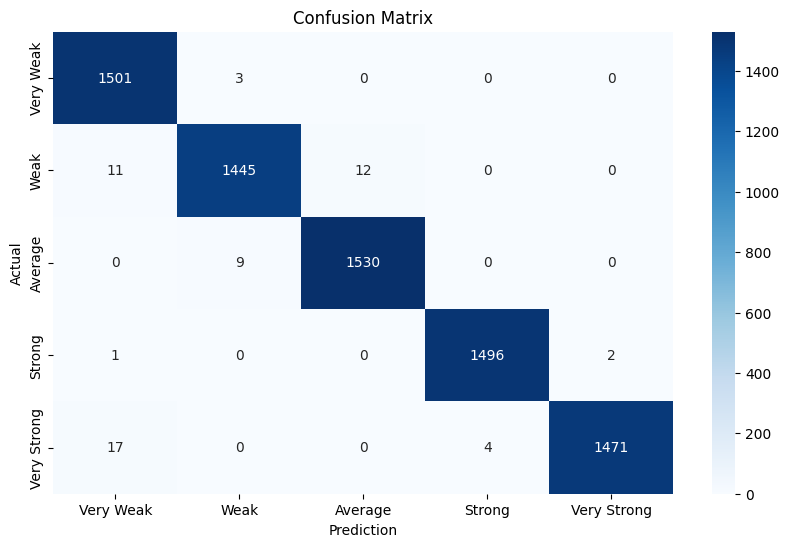

In [180]:
print(f'Current accuracy: {accuracy:.2f}%\n')

# Data used for the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predict)
class_order = ['Very Weak', 'Weak', 'Average', 'Strong', 'Very Strong']

# Gnereate heat map from cm data
pyplot.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_order, yticklabels=class_order)
pyplot.xlabel('Prediction')
pyplot.ylabel('Actual')
pyplot.title('Confusion Matrix')
pyplot.show()

<p>The model is trained upon a new session of this tool, meaning every time you use this tool the model is different, and therefore the accuracy is different. The model is trained with 70% of the dataset and tested with 30%, 25,000 passwords are used in total. Below the accuracy score is the confusion matrix, which visualizes exactly what the model is getting right and wrong.</p>

In [181]:
user_input = widgets.Text(
    value='',
    placeholder='Type the password you would like categorized'
)



# Function to prevent spaces from input
def del_spaces(change):
    new_user_input = change['new'].replace(' ', '')
    # Update the text input widget value if it contains spaces
    if new_user_input != change['new']:
        user_input.value = new_user_input

# Attach the handler to the text input widget
user_input.observe(del_spaces, names='value')


# Display the widget
display(user_input)


Text(value='', placeholder='Type the password you would like categorized')

In [182]:
# function that passes user_input to the model for strength prediction
def predict_strength(user_input):
    features = extract_features(user_input)
    features_df = pd.DataFrame([features])
    features_df = features_df[X_train.columns]
    strength = model.predict(features_df)
    return strength[0]

In [184]:
# Output widget
output = widgets.Output()

# Button widget
button = widgets.Button(
    description='Categorize!'
)

# Function to handle button click
def on_button_click(b):
    with output:
        # Clear output
        output.clear_output()
        entered_user_input = user_input.value  
        print(f'Predicted Strength: {predict_strength(entered_user_input)}')


# call buttion function
button.on_click(on_button_click)

display(button, output)

Button(description='Categorize!', style=ButtonStyle())

Output()

<br>
<p>Note: this tool does not store passwords, once the session ends all passwords entered are permanently discarded.</p>